In [79]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree
from tabulate import tabulate
import seaborn as sns
import re


### Generating the synthetic dataset for spam detection

In [88]:
size = 1000

In [89]:

# Set the random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for spam detection
data = {
    "Anzahl Wörter Betreff": np.random.poisson(5, size),
    "Verwendung von Spam-Wörtern": np.random.poisson(3, size), # Verwendung von Spam-Wörtern im Text: Anzahl der typischen Spam-Wörter wie "gratis", "Gewinn", "Sonderangebot", usw.
    "Anzahl Links": np.random.poisson(2, size),
    "Anzahl Empfänger": np.random.poisson(10, size),
    "Textlänge Nachricht": np.random.normal(500, 150, size).astype(int),
    "Anteil Großbuchstaben": np.random.beta(2, 5, size).round(2)
}

# Creating DataFrame
df = pd.DataFrame(data)
conditions = [
    (df['Verwendung von Spam-Wörtern'] > 1) | (df['Anzahl Links'] > 1),
    (df['Anzahl Empfänger'] > 15) | (df['Anteil Großbuchstaben'] > 0.5)
]
choices = [1, 1]  # Mark as spam
df['Ist Spam'] = np.select(conditions, choices, default=0)  # Default to not spam

df.head()


,Anzahl Wörter Betreff,Verwendung von Spam-Wörtern,Anzahl Links,Anzahl Empfänger,Textlänge Nachricht,Anteil Großbuchstaben,Ist Spam
0,5,0,1,14,475,0.46,0
1,4,4,1,9,321,0.24,1
2,4,3,4,9,529,0.19,1
3,5,4,5,11,654,0.20,1
4,5,4,1,9,467,0.15,1


### Splitting data into training and testing sets

In [112]:

# Splitting data
X = df.drop('Ist Spam', axis=1)
y = df['Ist Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Training the Random Forest model

In [115]:

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, random_state=42)

### Making predictions and evaluating the model

In [109]:

# Making predictions
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00       281

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



### Plotting feature importances

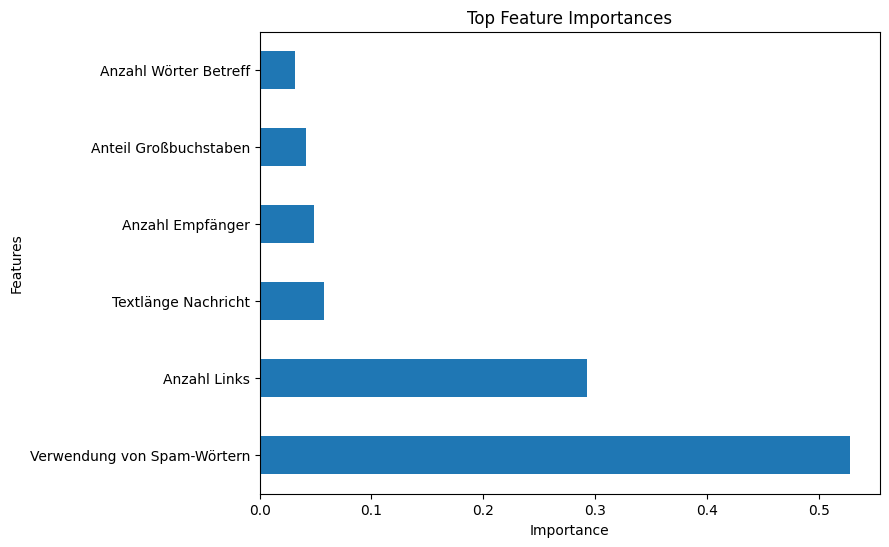

In [110]:

# Plotting feature importances
plt.figure(figsize=(8, 6))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


### Plotting confusion matrix

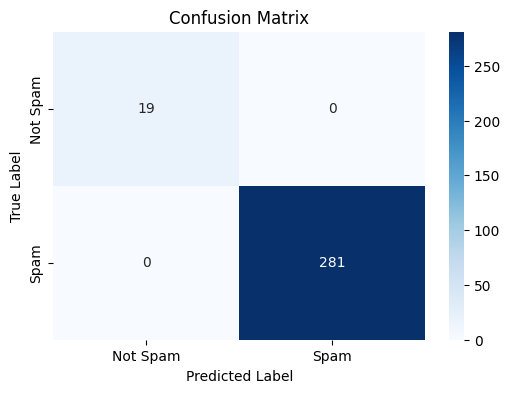

In [111]:

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Plotting a decision tree from the Random Forest

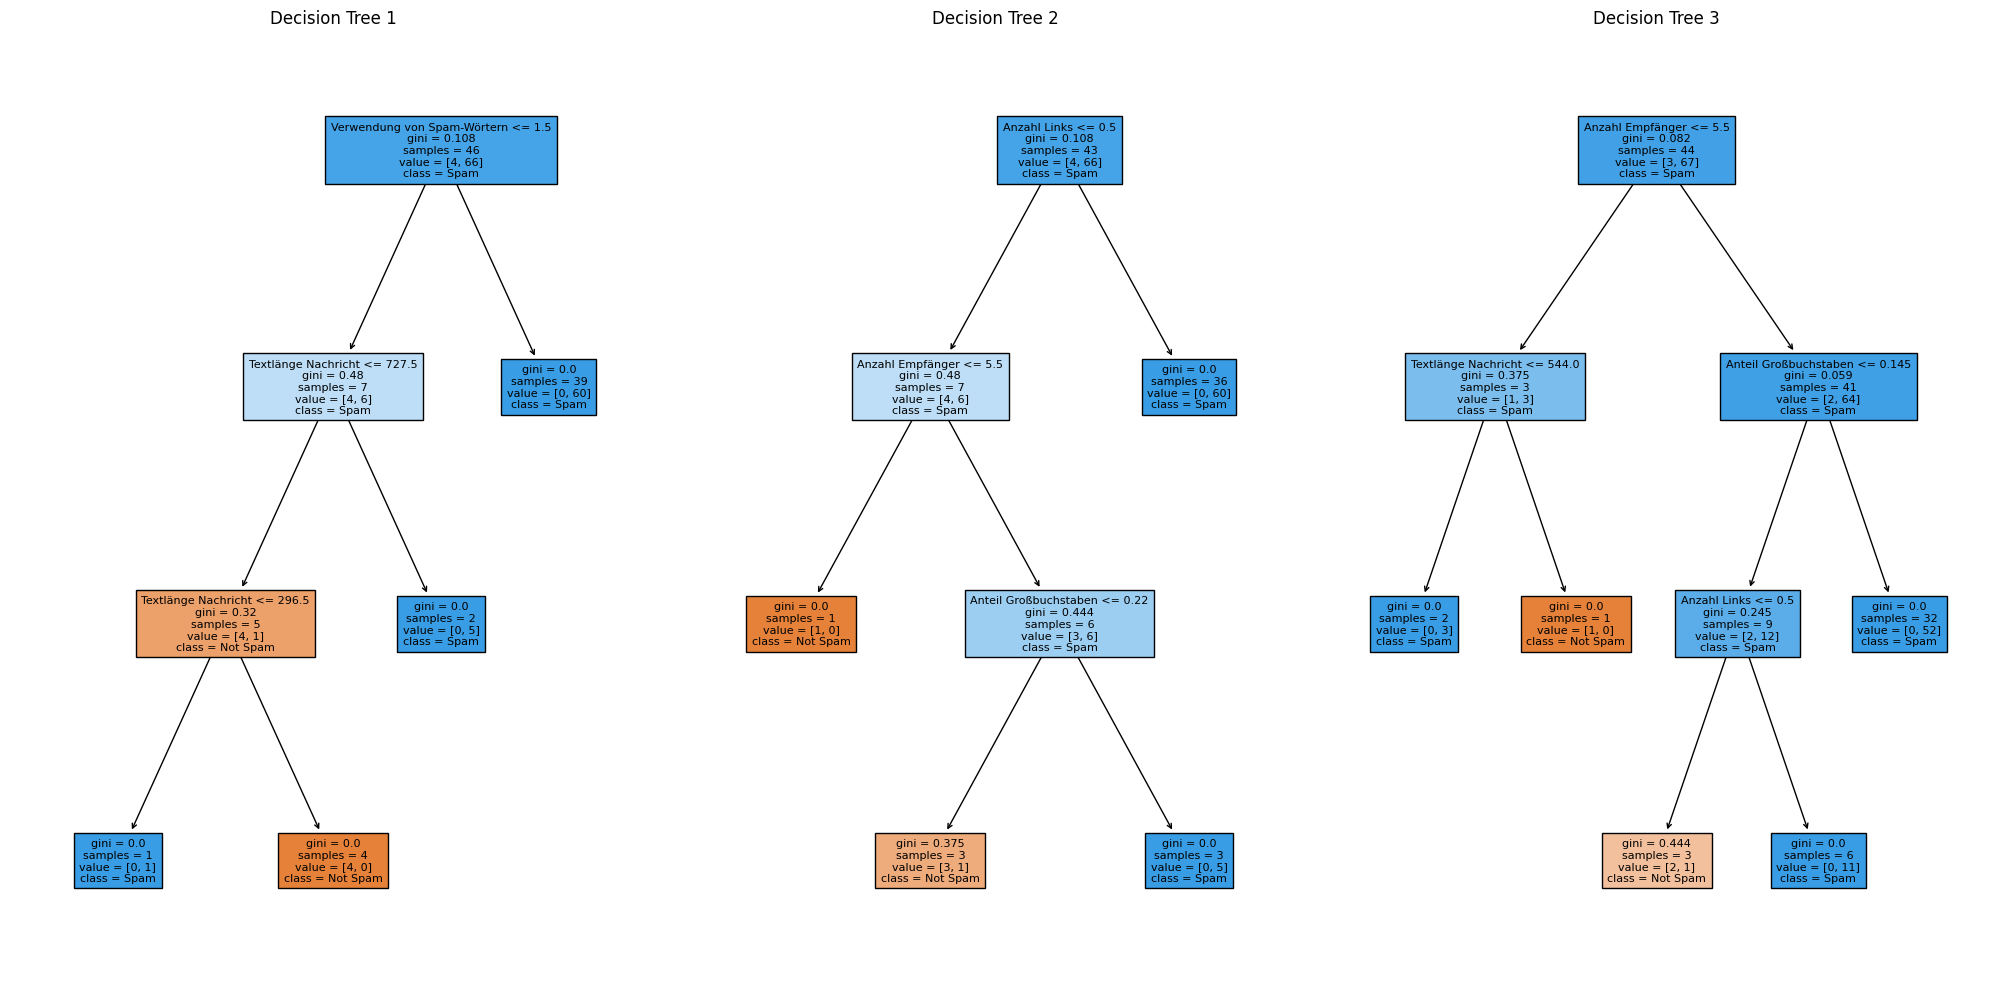

In [29]:
# Number of trees to plot
n_trees_to_plot = 3

# Create subplots
fig, axs = plt.subplots(1, n_trees_to_plot, figsize=(20, 10))

# Plotting multiple decision trees side by side
for i in range(n_trees_to_plot):
    plot_tree(rf_model.estimators_[i], feature_names=X.columns, class_names=['Not Spam', 'Spam'], filled=True, ax=axs[i], fontsize=8)
    axs[i].set_title(f'Decision Tree {i+1}')

plt.tight_layout()
plt.show()

In [116]:

# --- Schritt 1: Definiere eine Mail im Plaintext ---
mail_text = """
Betreff: Großes Gewinnspiel – Jetzt mitmachen und gewinnen!
Hallo, 
dies ist Ihre Chance, ein großes Preisgeld zu gewinnen! Klicken Sie auf den folgenden Link, um mehr zu erfahren: 
http://gewinnspiel.com. 
Teilen Sie diese E-Mail mit Ihren Freunden und erhöhen Sie Ihre Chancen!
"""



print("\nOriginal-Mail:\n")
print(mail_text)


Original-Mail:


Betreff: Wichtige Projektbesprechung am Montag
Hallo Team,

ich möchte euch daran erinnern, dass wir am kommenden Montag um 10 Uhr unsere wöchentliche Projektbesprechung haben.
Bitte bringt alle notwendigen Unterlagen mit. 

Vielen Dank und bis dahin.

Beste Grüße,
Ihr Projektleiter



### --- Schritt 2: Extrahiere Features aus der Mail ---

In [117]:
# Feature 1: Anzahl Wörter in der Betreffzeile
betreff_match = re.search(r"Betreff: (.*)", mail_text)
if betreff_match:
    betreff_text = betreff_match.group(1)
    anzahl_woerter_betreff = len(betreff_text.split())
else:
    anzahl_woerter_betreff = 0

print(f"\nAnzahl Wörter im Betreff: {anzahl_woerter_betreff}")


Anzahl Wörter im Betreff: 4


In [118]:
# Feature 2: Anzahl von typischen Spam-Wörtern (z.B. "Gewinn", "gratis", "Sonderangebot")
spam_woerter = ["gewinn", "gratis", "sonderangebot", "preisgeld", "jetzt", "aktion", "rabatt"]
verwendung_spam_woerter = sum(1 for wort in spam_woerter if re.search(rf"\b{wort}\b", mail_text, re.IGNORECASE))

print(f"Anzahl verwendeter Spam-Wörter: {verwendung_spam_woerter}")

Anzahl verwendeter Spam-Wörter: 0


In [119]:
# Feature 3: Anzahl Links in der Nachricht
anzahl_links = len(re.findall(r"http[s]?://", mail_text))
print(f"Anzahl Links im Text: {anzahl_links}")

Anzahl Links im Text: 0


In [120]:
# Feature 4: Textlänge der Nachricht (Anzahl Zeichen im Text)
textlaenge_nachricht = len(mail_text)
print(f"Textlänge der Nachricht (in Zeichen): {textlaenge_nachricht}")

Textlänge der Nachricht (in Zeichen): 285


In [121]:
# Feature 5: Anteil an Großbuchstaben im gesamten Text
grossbuchstaben_anteil = sum(1 for char in mail_text if char.isupper()) / len(mail_text)
print(f"Anteil der Großbuchstaben: {grossbuchstaben_anteil:.2f}")

Anteil der Großbuchstaben: 0.06




### --- Schritt 3: Speichere die extrahierten Features in einem DataFrame ---

In [122]:
anzahl_empfaenger = 1
feature_table = pd.DataFrame({
    "Feature": ["Anzahl Wörter Betreff", "Verwendung von Spam-Wörtern", "Anzahl Links", 
                "Anzahl Empfänger", "Textlänge Nachricht", "Anteil Großbuchstaben"],
    "Wert": [anzahl_woerter_betreff, verwendung_spam_woerter, anzahl_links, 
             anzahl_empfaenger, textlaenge_nachricht, f"{grossbuchstaben_anteil:.2%}"]
})

print("\nFeature-Tabelle:\n")
print(tabulate(feature_table, headers="keys", tablefmt="grid"))

new_mail_features = pd.DataFrame({
    "Anzahl Wörter Betreff": [anzahl_woerter_betreff],
    "Verwendung von Spam-Wörtern": [verwendung_spam_woerter],
    "Anzahl Links": [anzahl_links],
    "Anzahl Empfänger": [anzahl_empfaenger],
    "Textlänge Nachricht": [textlaenge_nachricht],
    "Anteil Großbuchstaben": [grossbuchstaben_anteil]
})



Feature-Tabelle:

+----+-----------------------------+--------+
|    | Feature                     | Wert   |
+====+=============================+========+
|  0 | Anzahl Wörter Betreff       | 4      |
+----+-----------------------------+--------+
|  1 | Verwendung von Spam-Wörtern | 0      |
+----+-----------------------------+--------+
|  2 | Anzahl Links                | 0      |
+----+-----------------------------+--------+
|  3 | Anzahl Empfänger            | 1      |
+----+-----------------------------+--------+
|  4 | Textlänge Nachricht         | 285    |
+----+-----------------------------+--------+
|  5 | Anteil Großbuchstaben       | 5.96%  |
+----+-----------------------------+--------+


### --- Schritt 4: Verwende das Modell, um eine Vorhersage zu machen ---

In [123]:

# Vorhersage für die extrahierten Features der Mail
prediction = rf_model.predict(new_mail_features)
prediction_proba = rf_model.predict_proba(new_mail_features)

# Ausgabe der Vorhersage
if prediction[0] == 1:
    print("\nDie E-Mail wird als Spam klassifiziert.")
else:
    print("\nDie E-Mail wird als Nicht-Spam klassifiziert.")

# Ausgabe der Vorhersagewahrscheinlichkeit
print(f"Wahrscheinlichkeit für Nicht-Spam: {prediction_proba[0][0]:.2f}")
print(f"Wahrscheinlichkeit für Spam: {prediction_proba[0][1]:.2f}")



Die E-Mail wird als Nicht-Spam klassifiziert.
Wahrscheinlichkeit für Nicht-Spam: 0.55
Wahrscheinlichkeit für Spam: 0.45


In [37]:
# another sample 
 
mail_text = """
Betreff: Wichtige Projektbesprechung am Montag
Hallo Team,

ich möchte euch daran erinnern, dass wir am kommenden Montag um 10 Uhr unsere wöchentliche Projektbesprechung haben.
Bitte bringt alle notwendigen Unterlagen mit. 

Vielen Dank und bis dahin.

Beste Grüße,
Ihr Projektleiter
"""